In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [2]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [5]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=False)
model.classifier = nn.Linear(2208, 3)
# fine tuning

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [8]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [10]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [11]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [12]:
model = model.to(device)

In [13]:
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 840/840train loss: 0.4798, acc: 0.7932
Duration :529.7572174072266 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 840/840train loss: 0.0842, acc: 0.9757
Duration :528.0282526016235 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 840/840train loss: 0.0474, acc: 0.9854
Duration :528.3708910942078 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 840/840train loss: 0.0354, acc: 0.9893
Duration :528.6466498374939 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 840/840train loss: 0.0219, acc: 0.9942
Duration :528.5488479137421 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 840/840train loss: 0.0255, acc: 0.9930
Duration :528.3958704471588 seconds
----------------------

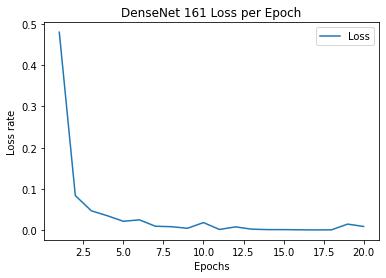

In [14]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("DenseNet 161 Loss per Epoch")
plt.legend()
plt.show()

In [15]:
print(lossLine)

[0.479750617076301, 0.08424944450708018, 0.04737999772962385, 0.03539182883779867, 0.021926969172957052, 0.025499182739196102, 0.009974590845859308, 0.008845133481207964, 0.00500751991337563, 0.01880104519513094, 0.0021390141964717805, 0.008426061298781456, 0.002904303963650587, 0.0018041448540034018, 0.001793984426430447, 0.001370587324892817, 0.0010654424426739138, 0.0013072582193544991, 0.015169541393543803, 0.00936213188068715]


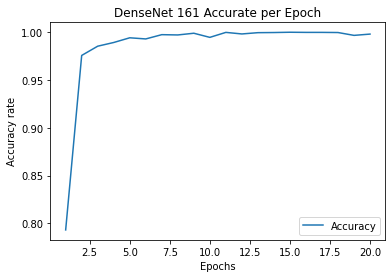

In [16]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("DenseNet 161 Accurate per Epoch")
plt.legend()
plt.show()

In [17]:
print(accLine)

[tensor(0.7932, device='cuda:0', dtype=torch.float64), tensor(0.9757, device='cuda:0', dtype=torch.float64), tensor(0.9854, device='cuda:0', dtype=torch.float64), tensor(0.9893, device='cuda:0', dtype=torch.float64), tensor(0.9942, device='cuda:0', dtype=torch.float64), tensor(0.9930, device='cuda:0', dtype=torch.float64), tensor(0.9975, device='cuda:0', dtype=torch.float64), tensor(0.9972, device='cuda:0', dtype=torch.float64), tensor(0.9990, device='cuda:0', dtype=torch.float64), tensor(0.9946, device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9982, device='cuda:0', dtype=torch.float64), tensor(0.9996, device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(0.9967, device='cuda:0',

In [18]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

              0
0  10573.035156


In [19]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.87      0.55      0.67       409
           1       0.40      0.44      0.42       367
           2       0.67      0.77      0.72       831

    accuracy                           0.64      1607
   macro avg       0.65      0.58      0.60      1607
weighted avg       0.66      0.64      0.64      1607



0.6365899191039204

In [21]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [22]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 175 label: 1 pred: 1
vid: 171 label: 0 pred: 2
vid: 190 label: 1 pred: 1
vid: 166 label: 1 pred: 2
vid: 169 label: 0 pred: 2
vid: 162 label: 1 pred: 1
vid: 179 label: 1 pred: 2
vid: 167 label: 2 pred: 2
vid: 195 label: 2 pred: 2
vid: 172 label: 2 pred: 1
vid: 170 label: 2 pred: 2
vid: 159 label: 1 pred: 2
vid: 191 label: 0 pred: 0
vid: 165 label: 0 pred: 0
vid: 161 label: 1 pred: 2
vid: 188 label: 2 pred: 2
vid: 189 label: 1 pred: 2
vid: 183 label: 0 pred: 0
vid: 160 label: 2 pred: 2
vid: 173 label: 2 pred: 2
vid: 184 label: 2 pred: 2
vid: 174 label: 1 pred: 0
vid: 180 label: 2 pred: 2
vid: 168 label: 0 pred: 0
vid: 158 label: 0 pred: 0
vid: 178 label: 0 pred: 0
vid: 182 label: 2 pred: 2
vid: 193 label: 2 pred: 2
vid: 163 label: 2 pred: 2
vid: 187 label: 2 pred: 2
vid: 176 label: 0 pred: 0
vid: 181 label: 0 pred: 1
vid: 157 label: 1 pred: 1
vid: 192 label: 0 pred: 0
vid: 177 label: 0 pred: 0
vid: 164 label: 2 pred: 2
vid: 185 label: 1 pred: 2
vid: 186 label: 1 pred: 2
vid: 194 lab

In [23]:
accuracy_score(y_true,y_pred)

0.6923076923076923